# Deep Learning Classification of Anomaly Peaks with 1D resnet
Using normal train/test split

In [12]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from sklearn import preprocessing
from resnet import ResNet1D
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn

sys.path.insert(1, "../")

from datasets import fdomDataset, fdomAugOnlyDataset


In [2]:
# Hyperparams
WINDOW_SIZE = 15 # the size of each data segment
TEST_SIZE = 0.10
SEED = 42
BATCH_SIZE = 32

In [3]:
# Paths to data files
fdom_raw_data = (
    "../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
)
stage_raw_data = "../Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = (
    "../Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"
)

fdom_labeled = "../Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"

fdom_raw_augmented = "../Data/augmented_data/fdom/unlabeled/unlabeled_fdom.csv"
fdom_labeled_augmented = "../Data/augmented_data/fdom/labeled/labeled_fdom_peaks.csv"

turb_augmented_raw_data = "../Data/augmented_data/fdom/unlabeled/unlabeled_turb.csv"

stage_augmented_data_fn = "../Data/augmented_data/fdom/unlabeled/unlabeled_stage.csv"


In [4]:
# get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


## Create dataset and dataloaders

In [5]:
# create dataset
classes = ["NAP", "FSK", "FPT", "PLP", "PP", "SKP"]
le = preprocessing.LabelEncoder()

targets = le.fit_transform(classes)

# train on class balanced data
train_dataset = fdomAugOnlyDataset(
    le,
    fdom_raw_augmented,
    stage_augmented_data_fn,
    turb_augmented_raw_data,
    fdom_labeled_augmented,
    window_size=WINDOW_SIZE
)

# test on unbalanced data
test_dataset = fdomDataset(
    le,
    fdom_raw_data,
    stage_raw_data,
    turb_raw_data,
    fdom_labeled,
    window_size=WINDOW_SIZE
)


/Users/claykaufmann/Projects/srrw-anomaly-detection/Deep_Learning/../Tools/get_candidates.py:221: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(
/Users/claykaufmann/Projects/srrw-anomaly-detection/Deep_Learning/../Tools/get_candidates.py:335: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

### Split into training/testing
This should not be the final iteration, this is just to get initial results.

In [6]:
# split data into training / testing

# create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [7]:
# init model
model = ResNet1D(
    in_channels=WINDOW_SIZE * 2 + 1,
    base_filters=64,
    kernel_size=16,
    stride=2,
    n_block=48,
    groups=1,  # check this
    n_classes=len(classes),
    downsample_gap=6,
    increasefilter_gap=12,
    verbose=False,
).to(device)

model = model.float()

# print a model summary
print(summary(model, (WINDOW_SIZE * 2 + 1, 6)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 64, 6]          31,808
   MyConv1dPadSame-2                [-1, 64, 6]               0
       BatchNorm1d-3                [-1, 64, 6]             128
              ReLU-4                [-1, 64, 6]               0
            Conv1d-5                [-1, 64, 6]          65,600
   MyConv1dPadSame-6                [-1, 64, 6]               0
       BatchNorm1d-7                [-1, 64, 6]             128
              ReLU-8                [-1, 64, 6]               0
           Dropout-9                [-1, 64, 6]               0
           Conv1d-10                [-1, 64, 6]          65,600
  MyConv1dPadSame-11                [-1, 64, 6]               0
       BasicBlock-12                [-1, 64, 6]               0
      BatchNorm1d-13                [-1, 64, 6]             128
             ReLU-14                [-1

## Init loss and optimizer

In [8]:
# Optimizer/criterion
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss().to(device)
all_loss = []


## Train Model

In [9]:
prog_bar = tqdm(trainloader, desc='Training', leave=False)
for i, batch in enumerate(prog_bar):
    x = batch[0].to(device)

    # squeeze y to flatten predictions into 1d tensor
    y = batch[1].squeeze().to(device)

    pred = model(x.float())

    loss = criterion(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    all_loss.append(loss.item())


## Test Model

Accuracy for class: NAP   is 5.1 %
Accuracy for class: FSK   is 0.0 %
Accuracy for class: FPT   is 0.0 %
Accuracy for class: PLP   is 15.4 %
Accuracy for class: PP    is 45.9 %
Accuracy for class: SKP   is 10.3 %
              precision    recall  f1-score   support

         FPT       0.00      0.00      0.00         1
         FSK       0.00      0.00      0.00         1
         NAP       0.89      0.05      0.10      1518
         PLP       0.01      0.15      0.02        26
          PP       0.03      0.46      0.06        61
         SKP       0.01      0.10      0.02        29

    accuracy                           0.07      1636
   macro avg       0.16      0.13      0.03      1636
weighted avg       0.82      0.07      0.09      1636



/opt/homebrew/Caskroom/miniforge/base/envs/srrw/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/srrw/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/srrw/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

<AxesSubplot:>

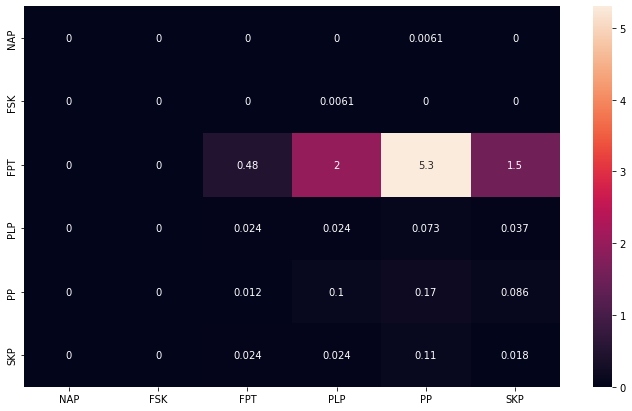

In [14]:
# Test model
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

y_pred = []
y_true = []

prog_bar = tqdm(testloader, desc="Testing", leave=False)
with torch.no_grad():
    for i, batch in enumerate(prog_bar):
        x = batch[0].to(device)

        y = batch[1].squeeze().to(device)

        outs = model(x.float())

        _, preds = torch.max(outs, 1)

        for label, prediction in zip(y, preds):
            # convert label and prediction to current vals
            label = le.inverse_transform([label])[0]
            prediction = le.inverse_transform([prediction])[0]

            y_pred.append(prediction)
            y_true.append(label)

            if label == prediction:
                correct_pred[label] += 1  # this may not work
            total_pred[label] += 1

for classname, correct_count in correct_pred.items():
    # because of unbalanced data, we need to not print out any classes that didn't have any labels
    if total_pred[classname] != 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")
    else:
        accuracy = 0.0
        print(f"CLASS NOT IN TEST BATCH: {classname:5s}")

# build conf matrix
conf = confusion_matrix(y_true, y_pred)

# review the classnames here
df_cm = pd.DataFrame(
    conf / np.sum(conf) * 10, index=[i for i in classes], columns=[i for i in classes]
)

# classification report
acc_report = classification_report(y_true, y_pred)
print(acc_report)

# display conf matrix
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)


## Display metrics

In [11]:
# TODO: implement displaying metrics